# --- classify cc voxels based on their gradient-prevalence profile ---

The subsequent code was used in Friedrich, Forkel & Thiebaut de Schotten, 2020 (https://www.researchgate.net/publication/339741859_Mapping_the_principal_gradient_onto_the_corpus_callosum) in the supplementary material.

The aim of the above referenced paper was to map the principal gradient onto the corpus callosum. The process of how we did this is shown below. For details please read the method section of the paper ;)

<img src="git_figs/01_wAverage_method.jpeg">

The result was a projection of the principal gradient onto the corpus callosum...

...However, other researchers may want to get a clear seperation of the callosal voxels (pointed out during the review process. So we thank the unknown reviewer for her/his suggestion! :) ).

Therefor, the following code is designed to create a hard-border segementation of the corpus callosum based on it's connectivity with cortical areas that are ordered by their similarity in resting-state fMRI (aka the principal gradient; Margulies et al., 2016, PNAS).

The result is shown below :)

<img src="git_figs/02_figureS1-B.jpeg">

##### import modules

In [1]:
### standard stuff
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### import modules for the tasks
import nibabel as nib # work with niftis
import umap           # dimension reduction
import hdbscan        # clustering

### evaluation:
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/Users/beaudet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### directories and apply mask (... and reshape for clustering --> later step)

In [13]:
##### requirements #####
# mask
ccMask = nib.load("./ccmask.nii.gz") # please change this path, if you use another mask!
ccMaskD = ccmask.get_fdata()
# visitation maps (sample-based tractograms to the distinct gradient levels)
discon_dir = "./discon"
# result directory
masked_discon = "./discon_masked"


##### a vessel for the clustering #####
df = []


##### create masked visitation maps #####
for grad in sorted(os.listdir(discon_dir)):
    if grad.startswith("grad") and grad.endswith ("nii.gz"):
        gradpath = discon_dir+"/"+grad
# get the visitation map infos
        img = nib.load(gradpath)
        img_header = img.header.copy()
        imgD = img.get_fdata()
# create masked image
        outn = grad.split(".")[0]+"_masked.nii.gz"   # define the name of file
        outp = "./discon_masked/"+outn   # define output path
        result = ccMaskD * imgD   # apply mask
# for later steps!!!
        ccMaskD_1d = ccMaskD.reshape(-1)
        result_masked = result.reshape(-1)[np.where(ccMaskD_1d)] # this reshapes to 1D and applies the mask
        df.append(result_masked)
# save result as nii.gz
        newImg = nib.nifti1.Nifti1Image(result, None, header=img_header) # create nii with correct header
        nib.save(newImg, outp) # save it :)
print(''' done :)''')


 done :)


##### dataframe for UMAP

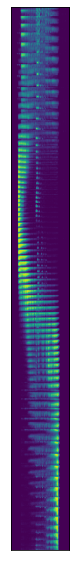

In [17]:
### convert to np.matrix
D = np.matrix(df)
dataT = D.T # transpose, as we are interested to reduce the number of gradient values

### only include the voxels from 13 to 82 grad value
dataT_13to82 = dataT[:,12:81]

### visualize the dataframe
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(dataT)
plt.show()

##### Test UMAP params - number of dimensions
UMAP reduces the dimensionality of the data, buw how many dimensions are "ideal"?
We run HDBSCAN (without changing any parameters) to see how many of the voxels in the ccMask can be classified. This will be our criteria.
The number of classified voxels will change depending on the number of dimensions.
In the following panel, we will pick the one number of dimensions with the highest number of classified voxels in this "vanila"-HDBSCAN run.

In [18]:
### vessel for UMAP_params
UMAP_params = {}
results = []

### find best params
for i in range(2, dataT.shape[1]+1):
    name = "clusterable_embedding_"+str(i)
# UMAP    
    UMAP_params[name] = umap.UMAP(
    random_state=25,
    n_neighbors=30,
    min_dist=0.0,
    n_components=i).fit_transform(dataT) # 
# HDBSCAN
    clusterer = hdbscan.HDBSCAN().fit(UMAP_params[name])
    label = hdbscan.HDBSCAN().fit_predict(UMAP_params[name])
    clustered = (label >= 0)
# result
    nrClusteredVoxels = np.sum(clustered) / dataT.shape[0]
    results.append(nrClusteredVoxels)
    print("{n} : {res}".format(n=name, res=nrClusteredVoxels))

clusterable_embedding_2 : 0.7829373650107991
clusterable_embedding_3 : 0.8218142548596112
clusterable_embedding_4 : 0.7451403887688985
clusterable_embedding_5 : 0.8120950323974082
clusterable_embedding_6 : 0.7775377969762419
clusterable_embedding_7 : 0.8056155507559395
clusterable_embedding_8 : 0.8401727861771058
clusterable_embedding_9 : 0.765658747300216
clusterable_embedding_10 : 0.7397408207343412
clusterable_embedding_11 : 0.8369330453563715
clusterable_embedding_12 : 0.8012958963282938
clusterable_embedding_13 : 0.8012958963282938
clusterable_embedding_14 : 0.787257019438445
clusterable_embedding_15 : 0.8045356371490281
clusterable_embedding_16 : 0.8099352051835853
clusterable_embedding_17 : 0.8099352051835853
clusterable_embedding_18 : 0.8326133909287257
clusterable_embedding_19 : 0.7991360691144709
clusterable_embedding_20 : 0.8704103671706264
clusterable_embedding_21 : 0.7883369330453563
clusterable_embedding_22 : 0.7764578833693304
clusterable_embedding_23 : 0.800215982721382

##### Test HDBSCAN params - cluster & sample size
After deciding which how many embedded dimensions we use, we can now look at the parameters in our clustering algorithm and try to optimize them. This time, the "best" parameters produce the highest number of classified voxels BUT at least 5 clusters (please see the excel-table in git_data called "infoHDBSCAN_paramTest).... you can obviously try out other goals for your optimization process.

In [20]:
### define embedding of interest (the one with the highest number of classified voxels)
emb = UMAP_params["clusterable_embedding_53"]

### vessel
infoHDBSCAN = []

### loop
for i in range(2, dataT.shape[1]+1):
    cName = "c"+str(i)+"_s"
    for j in range(2, dataT.shape[1]+1):
        name = cName+str(j)
        # clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit(emb)
        label = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit_predict(emb)
        # evaluation
        clustered = (label >= 0)
        percentClassifiedVoxels = np.sum(clustered) / dataT.shape[0]
        res = name+" "+str(percentClassifiedVoxels)+" "+str(label.max())
        infoHDBSCAN.append(res)
        print(res)
        

### save this all as a searchable txt-file
with open('./infoHDBSCAN_paramTest.txt', 'w') as f:
    for line in infoHDBSCAN:
        f.write(line+"\n")
print('done')

c2_s2 0.7807775377969762 124
c2_s3 0.7829373650107991 74
c2_s4 0.7829373650107991 54
c2_s5 0.8012958963282938 37
c2_s6 0.7948164146868251 27
c2_s7 0.7386609071274298 32
c2_s8 0.8704103671706264 16
c2_s9 0.8531317494600432 17
c2_s10 0.8596112311015118 16
c2_s11 0.8207343412526998 17
c2_s12 0.787257019438445 16
c2_s13 0.8045356371490281 16
c2_s14 0.7991360691144709 15
c2_s15 0.7775377969762419 13
c2_s16 0.7516198704103672 14
c2_s17 0.7278617710583153 14
c2_s18 0.7159827213822895 14
c2_s19 0.6965442764578834 14
c2_s20 0.6976241900647948 15
c2_s21 0.7084233261339092 12
c2_s22 0.7105831533477321 12
c2_s23 0.9254859611231101 4
c2_s24 0.9071274298056156 4
c2_s25 0.927645788336933 3
c2_s26 0.927645788336933 4
c2_s27 0.9676025917926566 2
c2_s28 0.908207343412527 3
c2_s29 0.9611231101511879 2
c2_s30 0.968682505399568 2
c2_s31 0.9071274298056156 4
c2_s32 0.958963282937365 2
c2_s33 0.9546436285097192 2
c2_s34 0.9546436285097192 2
c2_s35 0.9514038876889849 2
c2_s36 0.9514038876889849 2
c2_s37 0.952

c4_s98 0.8833693304535637 1
c4_s99 0.8822894168466523 1
c4_s100 0.8801295896328294 1
c5_s2 0.8401727861771058 56
c5_s3 0.8218142548596112 41
c5_s4 0.8153347732181425 34
c5_s5 0.8153347732181425 28
c5_s6 0.7926565874730022 25
c5_s7 0.8628509719222462 17
c5_s8 0.8704103671706264 16
c5_s9 0.8725701943844493 16
c5_s10 0.8455723542116631 16
c5_s11 0.8207343412526998 17
c5_s12 0.7948164146868251 15
c5_s13 0.7958963282937365 13
c5_s14 0.7786177105831533 14
c5_s15 0.7775377969762419 13
c5_s16 0.9265658747300216 5
c5_s17 0.7278617710583153 14
c5_s18 0.7408207343412527 13
c5_s19 0.7235421166306696 12
c5_s20 0.6976241900647948 13
c5_s21 0.7084233261339092 12
c5_s22 0.9200863930885529 4
c5_s23 0.9254859611231101 4
c5_s24 0.9190064794816415 3
c5_s25 0.927645788336933 3
c5_s26 0.9308855291576674 3
c5_s27 0.9676025917926566 2
c5_s28 0.908207343412527 3
c5_s29 0.9611231101511879 2
c5_s30 0.968682505399568 2
c5_s31 0.9632829373650108 2
c5_s32 0.958963282937365 2
c5_s33 0.9546436285097192 2
c5_s34 0.954

c7_s95 0.8984881209503239 1
c7_s96 0.8887688984881209 1
c7_s97 0.8844492440604752 1
c7_s98 0.8833693304535637 1
c7_s99 0.8822894168466523 1
c7_s100 0.8801295896328294 1
c8_s2 0.8747300215982722 32
c8_s3 0.8131749460043196 35
c8_s4 0.826133909287257 27
c8_s5 0.8207343412526998 23
c8_s6 0.7904967602591793 21
c8_s7 0.8563714902807775 16
c8_s8 0.8801295896328294 15
c8_s9 0.8725701943844493 16
c8_s10 0.8390928725701944 15
c8_s11 0.8185745140388769 14
c8_s12 0.7894168466522679 14
c8_s13 0.7958963282937365 13
c8_s14 0.7786177105831533 14
c8_s15 0.7775377969762419 13
c8_s16 0.9427645788336934 4
c8_s17 0.7397408207343412 13
c8_s18 0.7473002159827213 12
c8_s19 0.927645788336933 4
c8_s20 0.9200863930885529 4
c8_s21 0.9287257019438445 4
c8_s22 0.9200863930885529 4
c8_s23 0.9254859611231101 4
c8_s24 0.9190064794816415 3
c8_s25 0.927645788336933 3
c8_s26 0.9308855291576674 3
c8_s27 0.9676025917926566 2
c8_s28 0.908207343412527 3
c8_s29 0.9611231101511879 2
c8_s30 0.968682505399568 2
c8_s31 0.9632829

c10_s89 0.9017278617710583 1
c10_s90 0.9017278617710583 1
c10_s91 0.9017278617710583 1
c10_s92 0.9006479481641468 1
c10_s93 0.9006479481641468 1
c10_s94 0.8995680345572354 1
c10_s95 0.8984881209503239 1
c10_s96 0.8887688984881209 1
c10_s97 0.8844492440604752 1
c10_s98 0.8833693304535637 1
c10_s99 0.8822894168466523 1
c10_s100 0.8801295896328294 1
c11_s2 0.8909287257019438 23
c11_s3 0.857451403887689 21
c11_s4 0.8110151187904968 22
c11_s5 0.8002159827213823 21
c11_s6 0.7883369330453563 18
c11_s7 0.8455723542116631 15
c11_s8 0.8693304535637149 14
c11_s9 0.8498920086393088 16
c11_s10 0.8390928725701944 15
c11_s11 0.8185745140388769 14
c11_s12 0.7894168466522679 14
c11_s13 0.7958963282937365 13
c11_s14 0.7786177105831533 14
c11_s15 0.7786177105831533 12
c11_s16 0.9427645788336934 4
c11_s17 0.9395248380129589 4
c11_s18 0.9384449244060475 4
c11_s19 0.927645788336933 4
c11_s20 0.9200863930885529 4
c11_s21 0.9287257019438445 4
c11_s22 0.9416846652267818 3
c11_s23 0.949244060475162 3
c11_s24 0.

c13_s77 0.908207343412527 1
c13_s78 0.9071274298056156 1
c13_s79 0.9049676025917927 1
c13_s80 0.9038876889848813 1
c13_s81 0.9049676025917927 1
c13_s82 0.9028077753779697 1
c13_s83 0.9028077753779697 1
c13_s84 0.9028077753779697 1
c13_s85 0.9028077753779697 1
c13_s86 0.9028077753779697 1
c13_s87 0.9028077753779697 1
c13_s88 0.9017278617710583 1
c13_s89 0.9017278617710583 1
c13_s90 0.9017278617710583 1
c13_s91 0.9017278617710583 1
c13_s92 0.9006479481641468 1
c13_s93 0.9006479481641468 1
c13_s94 0.8995680345572354 1
c13_s95 0.8984881209503239 1
c13_s96 0.8887688984881209 1
c13_s97 0.8844492440604752 1
c13_s98 0.8833693304535637 1
c13_s99 0.8822894168466523 1
c13_s100 0.8801295896328294 1
c14_s2 0.8822894168466523 18
c14_s3 0.8401727861771058 16
c14_s4 0.7624190064794817 18
c14_s5 0.7699784017278618 17
c14_s6 0.7645788336933045 16
c14_s7 0.8423326133909287 13
c14_s8 0.8455723542116631 14
c14_s9 0.8498920086393088 14
c14_s10 0.8272138228941684 14
c14_s11 0.8185745140388769 14
c14_s12 0.78

c16_s65 0.9460043196544277 1
c16_s66 0.9438444924406048 1
c16_s67 0.9427645788336934 1
c16_s68 0.9362850971922246 1
c16_s69 0.9298056155507559 1
c16_s70 0.9298056155507559 1
c16_s71 0.9298056155507559 1
c16_s72 0.9352051835853131 1
c16_s73 0.9395248380129589 1
c16_s74 0.9092872570194385 1
c16_s75 0.908207343412527 1
c16_s76 0.9092872570194385 1
c16_s77 0.908207343412527 1
c16_s78 0.9071274298056156 1
c16_s79 0.9049676025917927 1
c16_s80 0.9038876889848813 1
c16_s81 0.9049676025917927 1
c16_s82 0.9028077753779697 1
c16_s83 0.9028077753779697 1
c16_s84 0.9028077753779697 1
c16_s85 0.9028077753779697 1
c16_s86 0.9028077753779697 1
c16_s87 0.9028077753779697 1
c16_s88 0.9017278617710583 1
c16_s89 0.9017278617710583 1
c16_s90 0.9017278617710583 1
c16_s91 0.9017278617710583 1
c16_s92 0.9006479481641468 1
c16_s93 0.9006479481641468 1
c16_s94 0.8995680345572354 1
c16_s95 0.8984881209503239 1
c16_s96 0.8887688984881209 1
c16_s97 0.8844492440604752 1
c16_s98 0.8833693304535637 1
c16_s99 0.882289

c19_s53 0.9298056155507559 2
c19_s54 0.9298056155507559 2
c19_s55 0.9233261339092873 2
c19_s56 0.91792656587473 2
c19_s57 0.9190064794816415 2
c19_s58 0.9146868250539957 2
c19_s59 0.9017278617710583 2
c19_s60 0.8984881209503239 2
c19_s61 0.8844492440604752 2
c19_s62 0.9460043196544277 1
c19_s63 0.949244060475162 1
c19_s64 0.9503239740820735 1
c19_s65 0.9460043196544277 1
c19_s66 0.9438444924406048 1
c19_s67 0.9427645788336934 1
c19_s68 0.9362850971922246 1
c19_s69 0.9298056155507559 1
c19_s70 0.9298056155507559 1
c19_s71 0.9298056155507559 1
c19_s72 0.9352051835853131 1
c19_s73 0.9395248380129589 1
c19_s74 0.9092872570194385 1
c19_s75 0.908207343412527 1
c19_s76 0.9092872570194385 1
c19_s77 0.908207343412527 1
c19_s78 0.9071274298056156 1
c19_s79 0.9049676025917927 1
c19_s80 0.9038876889848813 1
c19_s81 0.9049676025917927 1
c19_s82 0.9028077753779697 1
c19_s83 0.9028077753779697 1
c19_s84 0.9028077753779697 1
c19_s85 0.9028077753779697 1
c19_s86 0.9028077753779697 1
c19_s87 0.902807775

c22_s40 0.9524838012958964 2
c22_s41 0.9395248380129589 2
c22_s42 0.9438444924406048 2
c22_s43 0.9449244060475162 2
c22_s44 0.9427645788336934 2
c22_s45 0.9427645788336934 2
c22_s46 0.9416846652267818 2
c22_s47 0.9416846652267818 2
c22_s48 0.937365010799136 2
c22_s49 0.9362850971922246 2
c22_s50 0.9341252699784017 2
c22_s51 0.9352051835853131 2
c22_s52 0.9298056155507559 2
c22_s53 0.9298056155507559 2
c22_s54 0.9298056155507559 2
c22_s55 0.9233261339092873 2
c22_s56 0.91792656587473 2
c22_s57 0.9190064794816415 2
c22_s58 0.9146868250539957 2
c22_s59 0.9017278617710583 2
c22_s60 0.8984881209503239 2
c22_s61 0.9578833693304536 1
c22_s62 0.9460043196544277 1
c22_s63 0.949244060475162 1
c22_s64 0.9503239740820735 1
c22_s65 0.9460043196544277 1
c22_s66 0.9438444924406048 1
c22_s67 0.9427645788336934 1
c22_s68 0.9362850971922246 1
c22_s69 0.9298056155507559 1
c22_s70 0.9298056155507559 1
c22_s71 0.9298056155507559 1
c22_s72 0.9352051835853131 1
c22_s73 0.9395248380129589 1
c22_s74 0.90928725

c25_s29 0.9611231101511879 2
c25_s30 0.968682505399568 2
c25_s31 0.9632829373650108 2
c25_s32 0.958963282937365 2
c25_s33 0.9546436285097192 2
c25_s34 0.9546436285097192 2
c25_s35 0.9514038876889849 2
c25_s36 0.9514038876889849 2
c25_s37 0.9524838012958964 2
c25_s38 0.9524838012958964 2
c25_s39 0.9481641468682506 2
c25_s40 0.9524838012958964 2
c25_s41 0.9395248380129589 2
c25_s42 0.9438444924406048 2
c25_s43 0.9449244060475162 2
c25_s44 0.9427645788336934 2
c25_s45 0.9427645788336934 2
c25_s46 0.9416846652267818 2
c25_s47 0.9416846652267818 2
c25_s48 0.937365010799136 2
c25_s49 0.9362850971922246 2
c25_s50 0.9341252699784017 2
c25_s51 0.9352051835853131 2
c25_s52 0.9298056155507559 2
c25_s53 0.9298056155507559 2
c25_s54 0.9298056155507559 2
c25_s55 0.9233261339092873 2
c25_s56 0.91792656587473 2
c25_s57 0.9190064794816415 2
c25_s58 0.9146868250539957 2
c25_s59 0.9017278617710583 2
c25_s60 0.8984881209503239 2
c25_s61 0.9578833693304536 1
c25_s62 0.9460043196544277 1
c25_s63 0.949244060

c28_s17 0.91792656587473 3
c28_s18 0.9157667386609071 3
c28_s19 0.9114470842332614 3
c28_s20 0.9503239740820735 3
c28_s21 0.9524838012958964 3
c28_s22 0.9416846652267818 3
c28_s23 0.949244060475162 3
c28_s24 0.9190064794816415 3
c28_s25 0.927645788336933 3
c28_s26 0.9308855291576674 3
c28_s27 0.9676025917926566 2
c28_s28 0.908207343412527 3
c28_s29 0.9611231101511879 2
c28_s30 0.968682505399568 2
c28_s31 0.9632829373650108 2
c28_s32 0.958963282937365 2
c28_s33 0.9546436285097192 2
c28_s34 0.9546436285097192 2
c28_s35 0.9514038876889849 2
c28_s36 0.9514038876889849 2
c28_s37 0.9524838012958964 2
c28_s38 0.9524838012958964 2
c28_s39 0.9481641468682506 2
c28_s40 0.9524838012958964 2
c28_s41 0.9395248380129589 2
c28_s42 0.9438444924406048 2
c28_s43 0.9449244060475162 2
c28_s44 0.9427645788336934 2
c28_s45 0.9427645788336934 2
c28_s46 0.9416846652267818 2
c28_s47 0.9416846652267818 2
c28_s48 0.937365010799136 2
c28_s49 0.9362850971922246 2
c28_s50 0.9341252699784017 2
c28_s51 0.935205183585

c31_s7 0.8596112311015118 7
c31_s8 0.7710583153347732 7
c31_s9 0.8110151187904968 8
c31_s10 0.7645788336933045 7
c31_s11 0.7775377969762419 7
c31_s12 0.7937365010799136 7
c31_s13 0.7602591792656588 7
c31_s14 0.7570194384449244 6
c31_s15 0.9449244060475162 3
c31_s16 0.9438444924406048 3
c31_s17 0.91792656587473 3
c31_s18 0.9157667386609071 3
c31_s19 0.9114470842332614 3
c31_s20 0.9503239740820735 3
c31_s21 0.9524838012958964 3
c31_s22 0.9416846652267818 3
c31_s23 0.949244060475162 3
c31_s24 0.9190064794816415 3
c31_s25 0.927645788336933 3
c31_s26 0.9308855291576674 3
c31_s27 0.9676025917926566 2
c31_s28 0.908207343412527 3
c31_s29 0.9611231101511879 2
c31_s30 0.968682505399568 2
c31_s31 0.9632829373650108 2
c31_s32 0.958963282937365 2
c31_s33 0.9546436285097192 2
c31_s34 0.9546436285097192 2
c31_s35 0.9514038876889849 2
c31_s36 0.9514038876889849 2
c31_s37 0.9524838012958964 2
c31_s38 0.9524838012958964 2
c31_s39 0.9481641468682506 2
c31_s40 0.9524838012958964 2
c31_s41 0.93952483801295

c33_s94 0.8995680345572354 1
c33_s95 0.8984881209503239 1
c33_s96 0.8887688984881209 1
c33_s97 0.8844492440604752 1
c33_s98 0.8833693304535637 1
c33_s99 0.8822894168466523 1
c33_s100 0.8801295896328294 1
c34_s2 0.9136069114470843 9
c34_s3 0.8585313174946004 9
c34_s4 0.8390928725701944 9
c34_s5 0.896328293736501 8
c34_s6 0.8920086393088553 8
c34_s7 0.8596112311015118 7
c34_s8 0.7710583153347732 7
c34_s9 0.8110151187904968 8
c34_s10 0.7645788336933045 7
c34_s11 0.785097192224622 6
c34_s12 0.8002159827213823 6
c34_s13 0.7602591792656588 6
c34_s14 0.9211663066954644 3
c34_s15 0.9449244060475162 3
c34_s16 0.9438444924406048 3
c34_s17 0.91792656587473 3
c34_s18 0.9157667386609071 3
c34_s19 0.9114470842332614 3
c34_s20 0.9503239740820735 3
c34_s21 0.9524838012958964 3
c34_s22 0.9416846652267818 3
c34_s23 0.949244060475162 3
c34_s24 0.9190064794816415 3
c34_s25 0.927645788336933 3
c34_s26 0.9308855291576674 3
c34_s27 0.9676025917926566 2
c34_s28 0.908207343412527 3
c34_s29 0.9611231101511879 2

c36_s82 0.9028077753779697 1
c36_s83 0.9028077753779697 1
c36_s84 0.9028077753779697 1
c36_s85 0.9028077753779697 1
c36_s86 0.9028077753779697 1
c36_s87 0.9028077753779697 1
c36_s88 0.9017278617710583 1
c36_s89 0.9017278617710583 1
c36_s90 0.9017278617710583 1
c36_s91 0.9017278617710583 1
c36_s92 0.9006479481641468 1
c36_s93 0.9006479481641468 1
c36_s94 0.8995680345572354 1
c36_s95 0.8984881209503239 1
c36_s96 0.8887688984881209 1
c36_s97 0.8844492440604752 1
c36_s98 0.8833693304535637 1
c36_s99 0.8822894168466523 1
c36_s100 0.8801295896328294 1
c37_s2 0.9136069114470843 9
c37_s3 0.8650107991360692 8
c37_s4 0.8509719222462203 8
c37_s5 0.908207343412527 7
c37_s6 0.9038876889848813 7
c37_s7 0.8596112311015118 7
c37_s8 0.7796976241900648 6
c37_s9 0.8120950323974082 7
c37_s10 0.7667386609071274 6
c37_s11 0.785097192224622 6
c37_s12 0.8002159827213823 6
c37_s13 0.7602591792656588 6
c37_s14 0.9211663066954644 3
c37_s15 0.9449244060475162 3
c37_s16 0.9438444924406048 3
c37_s17 0.9179265658747

c39_s72 0.9352051835853131 1
c39_s73 0.9395248380129589 1
c39_s74 0.9092872570194385 1
c39_s75 0.908207343412527 1
c39_s76 0.9092872570194385 1
c39_s77 0.908207343412527 1
c39_s78 0.9071274298056156 1
c39_s79 0.9049676025917927 1
c39_s80 0.9038876889848813 1
c39_s81 0.9049676025917927 1
c39_s82 0.9028077753779697 1
c39_s83 0.9028077753779697 1
c39_s84 0.9028077753779697 1
c39_s85 0.9028077753779697 1
c39_s86 0.9028077753779697 1
c39_s87 0.9028077753779697 1
c39_s88 0.9017278617710583 1
c39_s89 0.9017278617710583 1
c39_s90 0.9017278617710583 1
c39_s91 0.9017278617710583 1
c39_s92 0.9006479481641468 1
c39_s93 0.9006479481641468 1
c39_s94 0.8995680345572354 1
c39_s95 0.8984881209503239 1
c39_s96 0.8887688984881209 1
c39_s97 0.8844492440604752 1
c39_s98 0.8833693304535637 1
c39_s99 0.8822894168466523 1
c39_s100 0.8801295896328294 1
c40_s2 0.9168466522678186 8
c40_s3 0.8650107991360692 8
c40_s4 0.8509719222462203 8
c40_s5 0.908207343412527 7
c40_s6 0.9038876889848813 7
c40_s7 0.859611231101

c42_s60 0.9481641468682506 1
c42_s61 0.9578833693304536 1
c42_s62 0.9460043196544277 1
c42_s63 0.949244060475162 1
c42_s64 0.9503239740820735 1
c42_s65 0.9460043196544277 1
c42_s66 0.9438444924406048 1
c42_s67 0.9427645788336934 1
c42_s68 0.9362850971922246 1
c42_s69 0.9298056155507559 1
c42_s70 0.9298056155507559 1
c42_s71 0.9298056155507559 1
c42_s72 0.9352051835853131 1
c42_s73 0.9395248380129589 1
c42_s74 0.9092872570194385 1
c42_s75 0.908207343412527 1
c42_s76 0.9092872570194385 1
c42_s77 0.908207343412527 1
c42_s78 0.9071274298056156 1
c42_s79 0.9049676025917927 1
c42_s80 0.9038876889848813 1
c42_s81 0.9049676025917927 1
c42_s82 0.9028077753779697 1
c42_s83 0.9028077753779697 1
c42_s84 0.9028077753779697 1
c42_s85 0.9028077753779697 1
c42_s86 0.9028077753779697 1
c42_s87 0.9028077753779697 1
c42_s88 0.9017278617710583 1
c42_s89 0.9017278617710583 1
c42_s90 0.9017278617710583 1
c42_s91 0.9017278617710583 1
c42_s92 0.9006479481641468 1
c42_s93 0.9006479481641468 1
c42_s94 0.8995680

c45_s50 0.9341252699784017 2
c45_s51 0.9352051835853131 2
c45_s52 0.9298056155507559 2
c45_s53 0.9298056155507559 2
c45_s54 0.9298056155507559 2
c45_s55 0.9233261339092873 2
c45_s56 0.91792656587473 2
c45_s57 0.9190064794816415 2
c45_s58 0.958963282937365 1
c45_s59 0.9524838012958964 1
c45_s60 0.9481641468682506 1
c45_s61 0.9578833693304536 1
c45_s62 0.9460043196544277 1
c45_s63 0.949244060475162 1
c45_s64 0.9503239740820735 1
c45_s65 0.9460043196544277 1
c45_s66 0.9438444924406048 1
c45_s67 0.9427645788336934 1
c45_s68 0.9362850971922246 1
c45_s69 0.9298056155507559 1
c45_s70 0.9298056155507559 1
c45_s71 0.9298056155507559 1
c45_s72 0.9352051835853131 1
c45_s73 0.9395248380129589 1
c45_s74 0.9092872570194385 1
c45_s75 0.908207343412527 1
c45_s76 0.9092872570194385 1
c45_s77 0.908207343412527 1
c45_s78 0.9071274298056156 1
c45_s79 0.9049676025917927 1
c45_s80 0.9038876889848813 1
c45_s81 0.9049676025917927 1
c45_s82 0.9028077753779697 1
c45_s83 0.9028077753779697 1
c45_s84 0.9028077753

c48_s40 0.9524838012958964 2
c48_s41 0.9395248380129589 2
c48_s42 0.9438444924406048 2
c48_s43 0.9449244060475162 2
c48_s44 0.9427645788336934 2
c48_s45 0.9427645788336934 2
c48_s46 0.9416846652267818 2
c48_s47 0.9416846652267818 2
c48_s48 0.937365010799136 2
c48_s49 0.9362850971922246 2
c48_s50 0.9341252699784017 2
c48_s51 0.9352051835853131 2
c48_s52 0.9298056155507559 2
c48_s53 0.9298056155507559 2
c48_s54 0.9298056155507559 2
c48_s55 0.9233261339092873 2
c48_s56 0.91792656587473 2
c48_s57 0.9600431965442765 1
c48_s58 0.958963282937365 1
c48_s59 0.9524838012958964 1
c48_s60 0.9481641468682506 1
c48_s61 0.9578833693304536 1
c48_s62 0.9460043196544277 1
c48_s63 0.949244060475162 1
c48_s64 0.9503239740820735 1
c48_s65 0.9460043196544277 1
c48_s66 0.9438444924406048 1
c48_s67 0.9427645788336934 1
c48_s68 0.9362850971922246 1
c48_s69 0.9298056155507559 1
c48_s70 0.9298056155507559 1
c48_s71 0.9298056155507559 1
c48_s72 0.9352051835853131 1
c48_s73 0.9395248380129589 1
c48_s74 0.909287257

c51_s28 0.908207343412527 3
c51_s29 0.9611231101511879 2
c51_s30 0.968682505399568 2
c51_s31 0.9632829373650108 2
c51_s32 0.958963282937365 2
c51_s33 0.9546436285097192 2
c51_s34 0.9546436285097192 2
c51_s35 0.9514038876889849 2
c51_s36 0.9514038876889849 2
c51_s37 0.9524838012958964 2
c51_s38 0.9524838012958964 2
c51_s39 0.9481641468682506 2
c51_s40 0.9524838012958964 2
c51_s41 0.9395248380129589 2
c51_s42 0.9438444924406048 2
c51_s43 0.9449244060475162 2
c51_s44 0.9427645788336934 2
c51_s45 0.9427645788336934 2
c51_s46 0.9416846652267818 2
c51_s47 0.9416846652267818 2
c51_s48 0.937365010799136 2
c51_s49 0.9362850971922246 2
c51_s50 0.9341252699784017 2
c51_s51 0.9352051835853131 2
c51_s52 0.9298056155507559 2
c51_s53 0.9298056155507559 2
c51_s54 0.9298056155507559 2
c51_s55 0.9233261339092873 2
c51_s56 0.9470842332613391 1
c51_s57 0.9600431965442765 1
c51_s58 0.958963282937365 1
c51_s59 0.9524838012958964 1
c51_s60 0.9481641468682506 1
c51_s61 0.9578833693304536 1
c51_s62 0.946004319

c54_s16 0.9438444924406048 3
c54_s17 0.91792656587473 3
c54_s18 0.9157667386609071 3
c54_s19 0.9114470842332614 3
c54_s20 0.9503239740820735 3
c54_s21 0.9524838012958964 3
c54_s22 0.9416846652267818 3
c54_s23 0.949244060475162 3
c54_s24 0.8617710583153347 2
c54_s25 0.8704103671706264 2
c54_s26 0.9308855291576674 3
c54_s27 0.9676025917926566 2
c54_s28 0.908207343412527 3
c54_s29 0.9611231101511879 2
c54_s30 0.968682505399568 2
c54_s31 0.9632829373650108 2
c54_s32 0.958963282937365 2
c54_s33 0.9546436285097192 2
c54_s34 0.9546436285097192 2
c54_s35 0.9514038876889849 2
c54_s36 0.9514038876889849 2
c54_s37 0.9524838012958964 2
c54_s38 0.9524838012958964 2
c54_s39 0.9481641468682506 2
c54_s40 0.9524838012958964 2
c54_s41 0.9395248380129589 2
c54_s42 0.9438444924406048 2
c54_s43 0.9449244060475162 2
c54_s44 0.9427645788336934 2
c54_s45 0.9427645788336934 2
c54_s46 0.9416846652267818 2
c54_s47 0.9416846652267818 2
c54_s48 0.937365010799136 2
c54_s49 0.9362850971922246 2
c54_s50 0.93412526997

c57_s6 0.8563714902807775 6
c57_s7 0.8099352051835853 6
c57_s8 0.7796976241900648 6
c57_s9 0.9611231101511879 5
c57_s10 0.906047516198704 4
c57_s11 0.9244060475161987 3
c57_s12 0.9427645788336934 3
c57_s13 0.9136069114470843 3
c57_s14 0.9211663066954644 3
c57_s15 0.9449244060475162 3
c57_s16 0.9438444924406048 3
c57_s17 0.91792656587473 3
c57_s18 0.9157667386609071 3
c57_s19 0.9114470842332614 3
c57_s20 0.9503239740820735 3
c57_s21 0.9524838012958964 3
c57_s22 0.8833693304535637 2
c57_s23 0.8898488120950324 2
c57_s24 0.8617710583153347 2
c57_s25 0.8704103671706264 2
c57_s26 0.9308855291576674 3
c57_s27 0.9719222462203023 1
c57_s28 0.9136069114470843 2
c57_s29 0.9611231101511879 2
c57_s30 0.9719222462203023 1
c57_s31 0.968682505399568 1
c57_s32 0.958963282937365 2
c57_s33 0.958963282937365 1
c57_s34 0.9578833693304536 1
c57_s35 0.9514038876889849 2
c57_s36 0.9611231101511879 1
c57_s37 0.9524838012958964 2
c57_s38 0.9524838012958964 2
c57_s39 0.9481641468682506 2
c57_s40 0.95248380129589

c59_s94 0.8995680345572354 1
c59_s95 0.8984881209503239 1
c59_s96 0.8887688984881209 1
c59_s97 0.8844492440604752 1
c59_s98 0.8833693304535637 1
c59_s99 0.8822894168466523 1
c59_s100 0.8801295896328294 1
c60_s2 0.91792656587473 7
c60_s3 0.8650107991360692 7
c60_s4 0.847732181425486 6
c60_s5 0.8563714902807775 6
c60_s6 0.8563714902807775 6
c60_s7 0.8099352051835853 6
c60_s8 0.9190064794816415 4
c60_s9 0.9611231101511879 5
c60_s10 0.906047516198704 4
c60_s11 0.9244060475161987 3
c60_s12 0.9427645788336934 3
c60_s13 0.9190064794816415 2
c60_s14 0.9211663066954644 3
c60_s15 0.9449244060475162 3
c60_s16 0.9438444924406048 3
c60_s17 0.91792656587473 3
c60_s18 0.9157667386609071 3
c60_s19 0.9114470842332614 3
c60_s20 0.9503239740820735 3
c60_s21 0.9524838012958964 3
c60_s22 0.8833693304535637 2
c60_s23 0.8898488120950324 2
c60_s24 0.8617710583153347 2
c60_s25 0.8704103671706264 2
c60_s26 0.9352051835853131 2
c60_s27 0.9719222462203023 1
c60_s28 0.9136069114470843 2
c60_s29 0.9654427645788337 

c62_s83 0.9028077753779697 1
c62_s84 0.9028077753779697 1
c62_s85 0.9028077753779697 1
c62_s86 0.9028077753779697 1
c62_s87 0.9028077753779697 1
c62_s88 0.9017278617710583 1
c62_s89 0.9017278617710583 1
c62_s90 0.9017278617710583 1
c62_s91 0.9017278617710583 1
c62_s92 0.9006479481641468 1
c62_s93 0.9006479481641468 1
c62_s94 0.8995680345572354 1
c62_s95 0.8984881209503239 1
c62_s96 0.8887688984881209 1
c62_s97 0.8844492440604752 1
c62_s98 0.8833693304535637 1
c62_s99 0.8822894168466523 1
c62_s100 0.8801295896328294 1
c63_s2 0.91792656587473 7
c63_s3 0.7980561555075594 6
c63_s4 0.7807775377969762 5
c63_s5 0.7894168466522679 5
c63_s6 0.7894168466522679 5
c63_s7 0.7429805615550756 5
c63_s8 0.8520518358531317 3
c63_s9 0.9611231101511879 5
c63_s10 0.9308855291576674 2
c63_s11 0.9308855291576674 2
c63_s12 0.949244060475162 2
c63_s13 0.9190064794816415 2
c63_s14 0.9244060475161987 2
c63_s15 0.8779697624190065 2
c63_s16 0.8768898488120951 2
c63_s17 0.8509719222462203 2
c63_s18 0.84881209503239

c65_s72 0.9352051835853131 1
c65_s73 0.9395248380129589 1
c65_s74 0.9092872570194385 1
c65_s75 0.908207343412527 1
c65_s76 0.9092872570194385 1
c65_s77 0.908207343412527 1
c65_s78 0.9071274298056156 1
c65_s79 0.9049676025917927 1
c65_s80 0.9038876889848813 1
c65_s81 0.9049676025917927 1
c65_s82 0.9028077753779697 1
c65_s83 0.9028077753779697 1
c65_s84 0.9028077753779697 1
c65_s85 0.9028077753779697 1
c65_s86 0.9028077753779697 1
c65_s87 0.9028077753779697 1
c65_s88 0.9017278617710583 1
c65_s89 0.9017278617710583 1
c65_s90 0.9017278617710583 1
c65_s91 0.9017278617710583 1
c65_s92 0.9006479481641468 1
c65_s93 0.9006479481641468 1
c65_s94 0.8995680345572354 1
c65_s95 0.8984881209503239 1
c65_s96 0.8887688984881209 1
c65_s97 0.8844492440604752 1
c65_s98 0.8833693304535637 1
c65_s99 0.8822894168466523 1
c65_s100 0.8801295896328294 1
c66_s2 1.0 1
c66_s3 0.7980561555075594 6
c66_s4 0.7807775377969762 5
c66_s5 0.8790496760259179 3
c66_s6 0.8920086393088553 3
c66_s7 0.8650107991360692 3
c66_s8 

c68_s63 0.949244060475162 1
c68_s64 0.9503239740820735 1
c68_s65 0.9460043196544277 1
c68_s66 0.9438444924406048 1
c68_s67 0.9427645788336934 1
c68_s68 0.9362850971922246 1
c68_s69 0.9298056155507559 1
c68_s70 0.9298056155507559 1
c68_s71 0.9298056155507559 1
c68_s72 0.9352051835853131 1
c68_s73 0.9395248380129589 1
c68_s74 0.9092872570194385 1
c68_s75 0.908207343412527 1
c68_s76 0.9092872570194385 1
c68_s77 0.908207343412527 1
c68_s78 0.9071274298056156 1
c68_s79 0.9049676025917927 1
c68_s80 0.9038876889848813 1
c68_s81 0.9049676025917927 1
c68_s82 0.9028077753779697 1
c68_s83 0.9028077753779697 1
c68_s84 0.9028077753779697 1
c68_s85 0.9028077753779697 1
c68_s86 0.9028077753779697 1
c68_s87 0.9028077753779697 1
c68_s88 0.9017278617710583 1
c68_s89 0.9017278617710583 1
c68_s90 0.9017278617710583 1
c68_s91 0.9017278617710583 1
c68_s92 0.9006479481641468 1
c68_s93 0.9006479481641468 1
c68_s94 0.8995680345572354 1
c68_s95 0.8984881209503239 1
c68_s96 0.8887688984881209 1
c68_s97 0.8844492

c71_s54 0.9514038876889849 1
c71_s55 0.9460043196544277 1
c71_s56 0.9470842332613391 1
c71_s57 0.9600431965442765 1
c71_s58 0.958963282937365 1
c71_s59 0.9524838012958964 1
c71_s60 0.9481641468682506 1
c71_s61 0.9578833693304536 1
c71_s62 0.9460043196544277 1
c71_s63 0.949244060475162 1
c71_s64 0.9503239740820735 1
c71_s65 0.9460043196544277 1
c71_s66 0.9438444924406048 1
c71_s67 0.9427645788336934 1
c71_s68 0.9362850971922246 1
c71_s69 0.9298056155507559 1
c71_s70 0.9298056155507559 1
c71_s71 0.9298056155507559 1
c71_s72 0.9352051835853131 1
c71_s73 0.9395248380129589 1
c71_s74 0.9092872570194385 1
c71_s75 0.908207343412527 1
c71_s76 0.9092872570194385 1
c71_s77 0.908207343412527 1
c71_s78 0.9071274298056156 1
c71_s79 0.9049676025917927 1
c71_s80 0.9038876889848813 1
c71_s81 0.9049676025917927 1
c71_s82 0.9028077753779697 1
c71_s83 0.9028077753779697 1
c71_s84 0.9028077753779697 1
c71_s85 0.9028077753779697 1
c71_s86 0.9028077753779697 1
c71_s87 0.9028077753779697 1
c71_s88 0.90172786

c74_s45 0.9481641468682506 1
c74_s46 0.9514038876889849 1
c74_s47 0.949244060475162 1
c74_s48 0.9470842332613391 1
c74_s49 0.9460043196544277 1
c74_s50 0.9481641468682506 1
c74_s51 0.9535637149028078 1
c74_s52 0.9470842332613391 1
c74_s53 0.9470842332613391 1
c74_s54 0.9514038876889849 1
c74_s55 0.9460043196544277 1
c74_s56 0.9470842332613391 1
c74_s57 0.9600431965442765 1
c74_s58 0.958963282937365 1
c74_s59 0.9524838012958964 1
c74_s60 0.9481641468682506 1
c74_s61 0.9578833693304536 1
c74_s62 0.9460043196544277 1
c74_s63 0.949244060475162 1
c74_s64 0.9503239740820735 1
c74_s65 0.9460043196544277 1
c74_s66 0.9438444924406048 1
c74_s67 0.9427645788336934 1
c74_s68 0.9362850971922246 1
c74_s69 0.9298056155507559 1
c74_s70 0.9298056155507559 1
c74_s71 0.9298056155507559 1
c74_s72 0.9352051835853131 1
c74_s73 0.9395248380129589 1
c74_s74 0.9092872570194385 1
c74_s75 0.908207343412527 1
c74_s76 0.9092872570194385 1
c74_s77 0.908207343412527 1
c74_s78 0.9071274298056156 1
c74_s79 0.904967602

c77_s33 0.958963282937365 1
c77_s34 0.9578833693304536 1
c77_s35 0.9600431965442765 1
c77_s36 0.9611231101511879 1
c77_s37 0.9622030237580994 1
c77_s38 0.958963282937365 1
c77_s39 0.9514038876889849 1
c77_s40 0.9578833693304536 1
c77_s41 0.9460043196544277 1
c77_s42 0.8812095032397408 1
c77_s43 0.9535637149028078 1
c77_s44 0.9514038876889849 1
c77_s45 0.9481641468682506 1
c77_s46 0.9514038876889849 1
c77_s47 0.949244060475162 1
c77_s48 0.9470842332613391 1
c77_s49 0.9460043196544277 1
c77_s50 0.9481641468682506 1
c77_s51 0.9535637149028078 1
c77_s52 0.9470842332613391 1
c77_s53 0.9470842332613391 1
c77_s54 0.9514038876889849 1
c77_s55 0.9460043196544277 1
c77_s56 0.9470842332613391 1
c77_s57 0.9600431965442765 1
c77_s58 0.958963282937365 1
c77_s59 0.9524838012958964 1
c77_s60 0.9481641468682506 1
c77_s61 0.9578833693304536 1
c77_s62 0.9460043196544277 1
c77_s63 0.949244060475162 1
c77_s64 0.9503239740820735 1
c77_s65 0.9460043196544277 1
c77_s66 0.9438444924406048 1
c77_s67 0.942764578

c80_s22 0.8833693304535637 2
c80_s23 0.8898488120950324 2
c80_s24 0.8617710583153347 2
c80_s25 0.8704103671706264 2
c80_s26 0.9352051835853131 2
c80_s27 0.9719222462203023 1
c80_s28 0.968682505399568 1
c80_s29 0.9654427645788337 1
c80_s30 0.9719222462203023 1
c80_s31 0.968682505399568 1
c80_s32 0.9600431965442765 1
c80_s33 0.958963282937365 1
c80_s34 0.9578833693304536 1
c80_s35 0.9600431965442765 1
c80_s36 0.9611231101511879 1
c80_s37 0.9622030237580994 1
c80_s38 0.958963282937365 1
c80_s39 0.9514038876889849 1
c80_s40 0.9578833693304536 1
c80_s41 0.9460043196544277 1
c80_s42 0.8812095032397408 1
c80_s43 0.9535637149028078 1
c80_s44 0.9514038876889849 1
c80_s45 0.9481641468682506 1
c80_s46 0.9514038876889849 1
c80_s47 0.949244060475162 1
c80_s48 0.9470842332613391 1
c80_s49 0.9460043196544277 1
c80_s50 0.9481641468682506 1
c80_s51 0.9535637149028078 1
c80_s52 0.9470842332613391 1
c80_s53 0.9470842332613391 1
c80_s54 0.9514038876889849 1
c80_s55 0.9460043196544277 1
c80_s56 0.947084233

c83_s12 0.949244060475162 2
c83_s13 0.9190064794816415 2
c83_s14 0.9244060475161987 2
c83_s15 0.8779697624190065 2
c83_s16 0.8768898488120951 2
c83_s17 0.8509719222462203 2
c83_s18 0.8488120950323974 2
c83_s19 0.8444924406047516 2
c83_s20 0.8822894168466523 2
c83_s21 0.8866090712742981 2
c83_s22 0.8833693304535637 2
c83_s23 0.8898488120950324 2
c83_s24 0.8617710583153347 2
c83_s25 0.8704103671706264 2
c83_s26 0.9352051835853131 2
c83_s27 0.9719222462203023 1
c83_s28 0.968682505399568 1
c83_s29 0.9654427645788337 1
c83_s30 0.9719222462203023 1
c83_s31 0.968682505399568 1
c83_s32 0.9600431965442765 1
c83_s33 0.958963282937365 1
c83_s34 0.9578833693304536 1
c83_s35 0.9600431965442765 1
c83_s36 0.9611231101511879 1
c83_s37 0.9622030237580994 1
c83_s38 0.958963282937365 1
c83_s39 0.9514038876889849 1
c83_s40 0.9578833693304536 1
c83_s41 0.9460043196544277 1
c83_s42 0.8812095032397408 1
c83_s43 0.9535637149028078 1
c83_s44 0.9514038876889849 1
c83_s45 0.9481641468682506 1
c83_s46 0.951403887

c85_s100 0.8801295896328294 1
c86_s2 0.6771058315334774 4
c86_s3 0.693304535637149 2
c86_s4 0.785097192224622 2
c86_s5 0.7948164146868251 2
c86_s6 0.8077753779697624 2
c86_s7 0.7807775377969762 2
c86_s8 0.7678185745140389 2
c86_s9 0.908207343412527 3
c86_s10 0.9308855291576674 2
c86_s11 0.9308855291576674 2
c86_s12 0.949244060475162 2
c86_s13 0.9190064794816415 2
c86_s14 0.9244060475161987 2
c86_s15 0.8779697624190065 2
c86_s16 0.9114470842332614 1
c86_s17 0.9103671706263499 1
c86_s18 0.9049676025917927 1
c86_s19 0.9028077753779697 1
c86_s20 0.8822894168466523 2
c86_s21 0.8866090712742981 2
c86_s22 0.8833693304535637 2
c86_s23 0.8898488120950324 2
c86_s24 0.8617710583153347 2
c86_s25 0.8704103671706264 2
c86_s26 0.9352051835853131 2
c86_s27 0.9719222462203023 1
c86_s28 0.968682505399568 1
c86_s29 0.9654427645788337 1
c86_s30 0.9719222462203023 1
c86_s31 0.968682505399568 1
c86_s32 0.9600431965442765 1
c86_s33 0.958963282937365 1
c86_s34 0.9578833693304536 1
c86_s35 0.9600431965442765 1

c88_s88 0.9017278617710583 1
c88_s89 0.9017278617710583 1
c88_s90 0.9017278617710583 1
c88_s91 0.9017278617710583 1
c88_s92 0.9006479481641468 1
c88_s93 0.9006479481641468 1
c88_s94 0.8995680345572354 1
c88_s95 0.8984881209503239 1
c88_s96 0.8887688984881209 1
c88_s97 0.8844492440604752 1
c88_s98 0.8833693304535637 1
c88_s99 0.8822894168466523 1
c88_s100 0.8801295896328294 1
c89_s2 0.6771058315334774 4
c89_s3 0.693304535637149 2
c89_s4 0.785097192224622 2
c89_s5 0.7948164146868251 2
c89_s6 0.8077753779697624 2
c89_s7 0.7807775377969762 2
c89_s8 0.7678185745140389 2
c89_s9 0.908207343412527 3
c89_s10 0.9308855291576674 2
c89_s11 0.9308855291576674 2
c89_s12 0.949244060475162 2
c89_s13 0.9190064794816415 2
c89_s14 0.9773218142548596 1
c89_s15 0.8779697624190065 2
c89_s16 0.9114470842332614 1
c89_s17 0.9103671706263499 1
c89_s18 0.9049676025917927 1
c89_s19 0.9028077753779697 1
c89_s20 0.8822894168466523 2
c89_s21 0.8866090712742981 2
c89_s22 0.8833693304535637 2
c89_s23 0.889848812095032

c91_s76 0.9092872570194385 1
c91_s77 0.908207343412527 1
c91_s78 0.9071274298056156 1
c91_s79 0.9049676025917927 1
c91_s80 0.9038876889848813 1
c91_s81 0.9049676025917927 1
c91_s82 0.9028077753779697 1
c91_s83 0.9028077753779697 1
c91_s84 0.9028077753779697 1
c91_s85 0.9028077753779697 1
c91_s86 0.9028077753779697 1
c91_s87 0.9028077753779697 1
c91_s88 0.9017278617710583 1
c91_s89 0.9017278617710583 1
c91_s90 0.9017278617710583 1
c91_s91 0.9017278617710583 1
c91_s92 0.9006479481641468 1
c91_s93 0.9006479481641468 1
c91_s94 0.8995680345572354 1
c91_s95 0.8984881209503239 1
c91_s96 0.8887688984881209 1
c91_s97 0.8844492440604752 1
c91_s98 0.8833693304535637 1
c91_s99 0.8822894168466523 1
c91_s100 0.8801295896328294 1
c92_s2 0.7181425485961123 2
c92_s3 0.693304535637149 2
c92_s4 0.8099352051835853 1
c92_s5 0.7948164146868251 2
c92_s6 0.8077753779697624 2
c92_s7 0.7807775377969762 2
c92_s8 0.7678185745140389 2
c92_s9 0.908207343412527 3
c92_s10 0.9308855291576674 2
c92_s11 0.93088552915766

c94_s64 0.9503239740820735 1
c94_s65 0.9460043196544277 1
c94_s66 0.9438444924406048 1
c94_s67 0.9427645788336934 1
c94_s68 0.9362850971922246 1
c94_s69 0.9298056155507559 1
c94_s70 0.9298056155507559 1
c94_s71 0.9298056155507559 1
c94_s72 0.9352051835853131 1
c94_s73 0.9395248380129589 1
c94_s74 0.9092872570194385 1
c94_s75 0.908207343412527 1
c94_s76 0.9092872570194385 1
c94_s77 0.908207343412527 1
c94_s78 0.9071274298056156 1
c94_s79 0.9049676025917927 1
c94_s80 0.9038876889848813 1
c94_s81 0.9049676025917927 1
c94_s82 0.9028077753779697 1
c94_s83 0.9028077753779697 1
c94_s84 0.9028077753779697 1
c94_s85 0.9028077753779697 1
c94_s86 0.9028077753779697 1
c94_s87 0.9028077753779697 1
c94_s88 0.9017278617710583 1
c94_s89 0.9017278617710583 1
c94_s90 0.9017278617710583 1
c94_s91 0.9017278617710583 1
c94_s92 0.9006479481641468 1
c94_s93 0.9006479481641468 1
c94_s94 0.8995680345572354 1
c94_s95 0.8984881209503239 1
c94_s96 0.8887688984881209 1
c94_s97 0.8844492440604752 1
c94_s98 0.883369

c97_s52 0.9470842332613391 1
c97_s53 0.9470842332613391 1
c97_s54 0.9514038876889849 1
c97_s55 0.9460043196544277 1
c97_s56 0.9470842332613391 1
c97_s57 0.9600431965442765 1
c97_s58 0.958963282937365 1
c97_s59 0.9524838012958964 1
c97_s60 0.9481641468682506 1
c97_s61 0.9578833693304536 1
c97_s62 0.9460043196544277 1
c97_s63 0.949244060475162 1
c97_s64 0.9503239740820735 1
c97_s65 0.9460043196544277 1
c97_s66 0.9438444924406048 1
c97_s67 0.9427645788336934 1
c97_s68 0.9362850971922246 1
c97_s69 0.9298056155507559 1
c97_s70 0.9298056155507559 1
c97_s71 0.9298056155507559 1
c97_s72 0.9352051835853131 1
c97_s73 0.9395248380129589 1
c97_s74 0.9092872570194385 1
c97_s75 0.908207343412527 1
c97_s76 0.9092872570194385 1
c97_s77 0.908207343412527 1
c97_s78 0.9071274298056156 1
c97_s79 0.9049676025917927 1
c97_s80 0.9038876889848813 1
c97_s81 0.9049676025917927 1
c97_s82 0.9028077753779697 1
c97_s83 0.9028077753779697 1
c97_s84 0.9028077753779697 1
c97_s85 0.9028077753779697 1
c97_s86 0.90280777

c100_s40 0.9578833693304536 1
c100_s41 0.9460043196544277 1
c100_s42 0.8812095032397408 1
c100_s43 0.9535637149028078 1
c100_s44 0.9514038876889849 1
c100_s45 0.9481641468682506 1
c100_s46 0.9514038876889849 1
c100_s47 0.949244060475162 1
c100_s48 0.9470842332613391 1
c100_s49 0.9460043196544277 1
c100_s50 0.9481641468682506 1
c100_s51 0.9535637149028078 1
c100_s52 0.9470842332613391 1
c100_s53 0.9470842332613391 1
c100_s54 0.9514038876889849 1
c100_s55 0.9460043196544277 1
c100_s56 0.9470842332613391 1
c100_s57 0.9600431965442765 1
c100_s58 0.958963282937365 1
c100_s59 0.9524838012958964 1
c100_s60 0.9481641468682506 1
c100_s61 0.9578833693304536 1
c100_s62 0.9460043196544277 1
c100_s63 0.949244060475162 1
c100_s64 0.9503239740820735 1
c100_s65 0.9460043196544277 1
c100_s66 0.9438444924406048 1
c100_s67 0.9427645788336934 1
c100_s68 0.9362850971922246 1
c100_s69 0.9298056155507559 1
c100_s70 0.9298056155507559 1
c100_s71 0.9298056155507559 1
c100_s72 0.9352051835853131 1
c100_s73 0.93

##### Visualize and save outputs :)
In our case, the "optimal" params were 11 and 2.... so we included these params in the following cell (i and j). The code below will give us the parcellation as nii.gz and some nice pictures :)

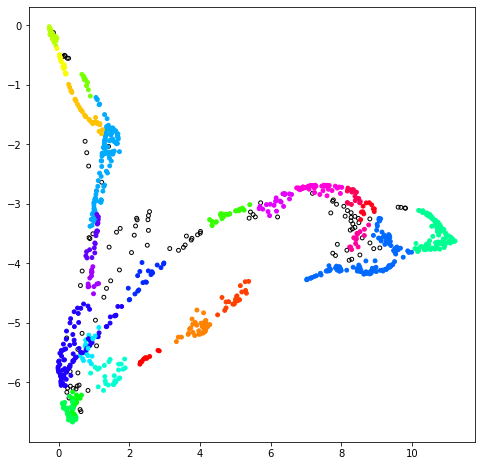

In [26]:
### clustering
i = 11
j = 2
clusterer = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit(emb)
label = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit_predict(emb)
clustered = (label >= 0)

### figure
fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='polar')
ax = fig.add_subplot(111)
clustered = (label >= 0)
ax.scatter(emb[~clustered, 0],
            emb[~clustered, 1],
            facecolors='none',
            edgecolors='black',
            s=15)
ax.scatter(emb[clustered, 0],
            emb[clustered, 1],
            c=label[clustered],
            s=15,
            cmap='hsv')
#plt.savefig('visualized_embedding.PDF')
plt.show()

### invert labels (so that the dark colour is for unimodal)
invert = (label-label.max())*-1
invert = np.where(invert < label.max(), invert, -1)
index = np.arange(len(ccMaskD_1d))
indexMasked = index[np.where(ccMaskD_1d)] # this contains only the 900+ indices needed
empty = np.zeros(len(ccMaskD_1d))
filled = empty
np.put(filled, indexMasked, invert) # inserts the label values at the position of CC
result = filled.reshape(ccMaskD.shape)

### output nifti
img = nib.nifti1.Nifti1Image(result, None, header=img_header)
img.get_data_dtype()
nib.save(img, "cc_parcellated.nii.gz")

##### If you use this code, please make sure to cite our work as well as the amazing(!) algorithms created by Leland McInnes:

Friedrich, P., Forkel, S. J., & de Schotten, M. T. (2020). Mapping the principal gradient onto the corpus callosum. bioRxiv.

McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.

McInnes, L., Healy, J., & Astels, S. (2017). hdbscan: Hierarchical density based clustering. Journal of Open Source Software, 2(11), 205.